In [35]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn import decomposition
from scipy import stats
from sklearn import cluster

matplotlib.style.use('fivethirtyeight')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (10,10)

In [64]:
train = pd.read_csv('C://Users//amank//OneDrive//Documents//NewYork_Taxi//train.csv')
# train = pd.read_csv('C://Users//amank//OneDrive//Documents//NewYork_Taxi//train.csv',infer_datetime_format=True, parse_dates=[2,3])

In [65]:
# remove obvious outliers
allLat  = np.array(list(train['pickup_latitude'])  + list(train['dropoff_latitude']))
allLong = np.array(list(train['pickup_longitude']) + list(train['dropoff_longitude']))

longLimits = [np.percentile(allLong, 0.3), np.percentile(allLong, 99.7)]
latLimits  = [np.percentile(allLat , 0.3), np.percentile(allLat , 99.7)]
durLimits  = [np.percentile(train['trip_duration'], 0.4), np.percentile(train['trip_duration'], 99.7)]

In [83]:
train = train[(train['pickup_latitude']   >= latLimits[0] ) & (train['pickup_latitude']   <= latLimits[1]) ]
train = train[(train['dropoff_latitude']  >= latLimits[0] ) & (train['dropoff_latitude']  <= latLimits[1]) ]
train = train[(train['pickup_longitude']  >= longLimits[0]) & (train['pickup_longitude']  <= longLimits[1])]
train = train[(train['dropoff_longitude'] >= longLimits[0]) & (train['dropoff_longitude'] <= longLimits[1])]
train = train[(train['trip_duration']     >= durLimits[0] ) & (train['trip_duration']     <= durLimits[1]) ]
train = train.reset_index(drop=True)

allLat  = np.array(list(train['pickup_latitude'])  + list(train['dropoff_latitude']))
allLong = np.array(list(train['pickup_longitude']) + list(train['dropoff_longitude']))

# convert fields to sensible units
medianLat  = np.percentile(allLat,50)
print("Median Lat ", medianLat)
medianLong = np.percentile(allLong,50)
print("Median Long ", medianLong)

#The equator is divided into 360 degrees of longitude
#so each degree at the equator represents 111,319.9 meters or approximately 111.32 km.
latMultiplier  = 111.32
longMultiplier = np.cos(medianLat*(np.pi/180.0)) * 111.32

train['duration [min]'] = train['trip_duration']/60.0
train['src lat [km]']   = latMultiplier  * (train['pickup_latitude']   - medianLat)
train['src long [km]']  = longMultiplier * (train['pickup_longitude']  - medianLong)
train['dst lat [km]']   = latMultiplier  * (train['dropoff_latitude']  - medianLat)
train['dst long [km]']  = longMultiplier * (train['dropoff_longitude'] - medianLong)

allLat  = np.array(list(train['src lat [km]'])  + list(train['dst lat [km]']))
allLong = np.array(list(train['src long [km]']) + list(train['dst long [km]']))


Median Lat  40.754581451416016
Median Long  -73.98097229003906


In [84]:
print(pd.Series(allLat).dropna().min())
print(pd.Series(allLat).dropna().max())

-12.577770538330077
10.889353790283202


Text(0.5,0,'longitude [km]')

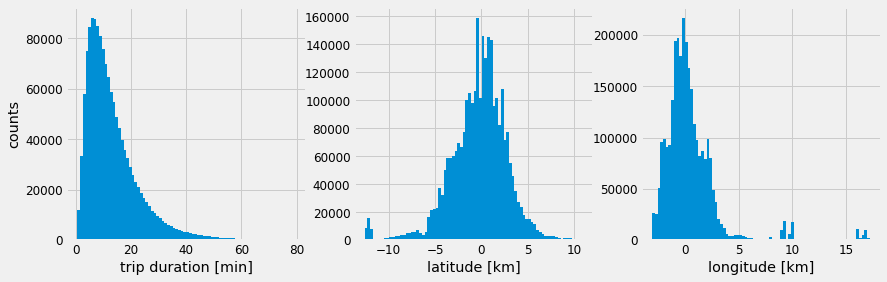

In [86]:
# make sure the ranges we chose are sensible
fig, axArray = plt.subplots(nrows=1,ncols=3,figsize=(13,4))
axArray[0].hist(train['duration [min]'],80); 
axArray[0].set_xlabel('trip duration [min]'); axArray[0].set_ylabel('counts')
axArray[1].hist(allLat ,80); axArray[1].set_xlabel('latitude [km]')
axArray[2].hist(allLong,80); axArray[2].set_xlabel('longitude [km]')

Text(0.5,1,'log of trip Duration vs Aerial trip Distance')

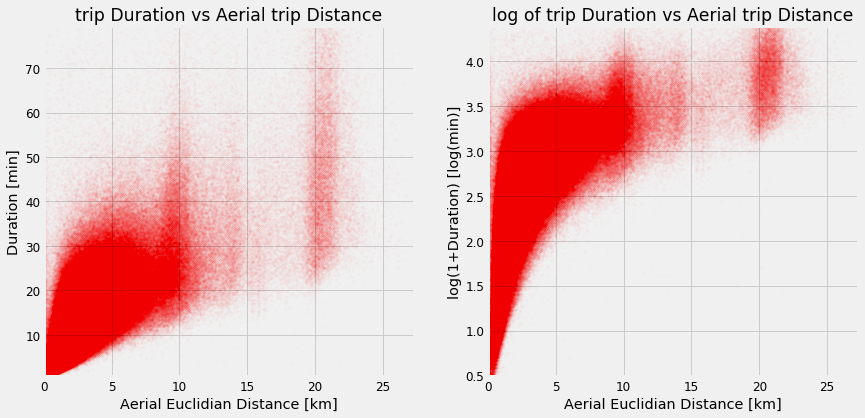

In [87]:
taxiDB = train.copy()
#%% plot scatter of trip duration vs. aerial distance between pickup and dropoff
taxiDB['log duration']       = np.log1p(taxiDB['duration [min]'])
taxiDB['euclidian distance'] = np.sqrt((taxiDB['src lat [km]']  - taxiDB['dst lat [km]'] )**2 + 
                                       (taxiDB['src long [km]'] - taxiDB['dst long [km]'])**2)

fig, axArray = plt.subplots(nrows=1,ncols=2,figsize=(13,6))
axArray[0].scatter(taxiDB['euclidian distance'], taxiDB['duration [min]'],c='r',s=5,alpha=0.01); 
axArray[0].set_xlabel('Aerial Euclidian Distance [km]'); axArray[0].set_ylabel('Duration [min]')
axArray[0].set_xlim(taxiDB['euclidian distance'].min(),taxiDB['euclidian distance'].max())
axArray[0].set_ylim(taxiDB['duration [min]'].min(),taxiDB['duration [min]'].max())
axArray[0].set_title('trip Duration vs Aerial trip Distance')

axArray[1].scatter(taxiDB['euclidian distance'], taxiDB['log duration'],c='r',s=5,alpha=0.01); 
axArray[1].set_xlabel('Aerial Euclidian Distance [km]'); axArray[1].set_ylabel('log(1+Duration) [log(min)]')
axArray[1].set_xlim(taxiDB['euclidian distance'].min(),taxiDB['euclidian distance'].max())
axArray[1].set_ylim(taxiDB['log duration'].min(),taxiDB['log duration'].max())
axArray[1].set_title('log of trip Duration vs Aerial trip Distance')

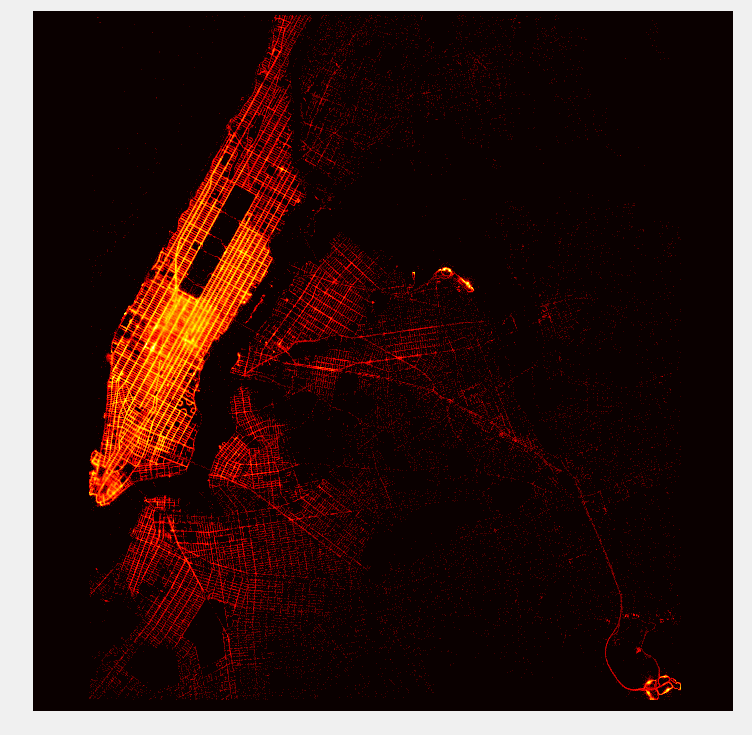

In [88]:
# show the log density of pickup and dropoff locations
imageSize = (700,700)
longRange = [-5,19]
latRange = [-13,11]

allLatInds  = imageSize[0] - (imageSize[0] * (allLat  - latRange[0])  / (latRange[1]  - latRange[0]) ).astype(int)
allLongInds =                (imageSize[1] * (allLong - longRange[0]) / (longRange[1] - longRange[0])).astype(int)

locationDensityImage = np.zeros(imageSize)
for latInd, longInd in zip(allLatInds,allLongInds):
    locationDensityImage[latInd,longInd] += 1

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,12))
ax.imshow(np.log(locationDensityImage+1),cmap='hot')
ax.set_axis_off()

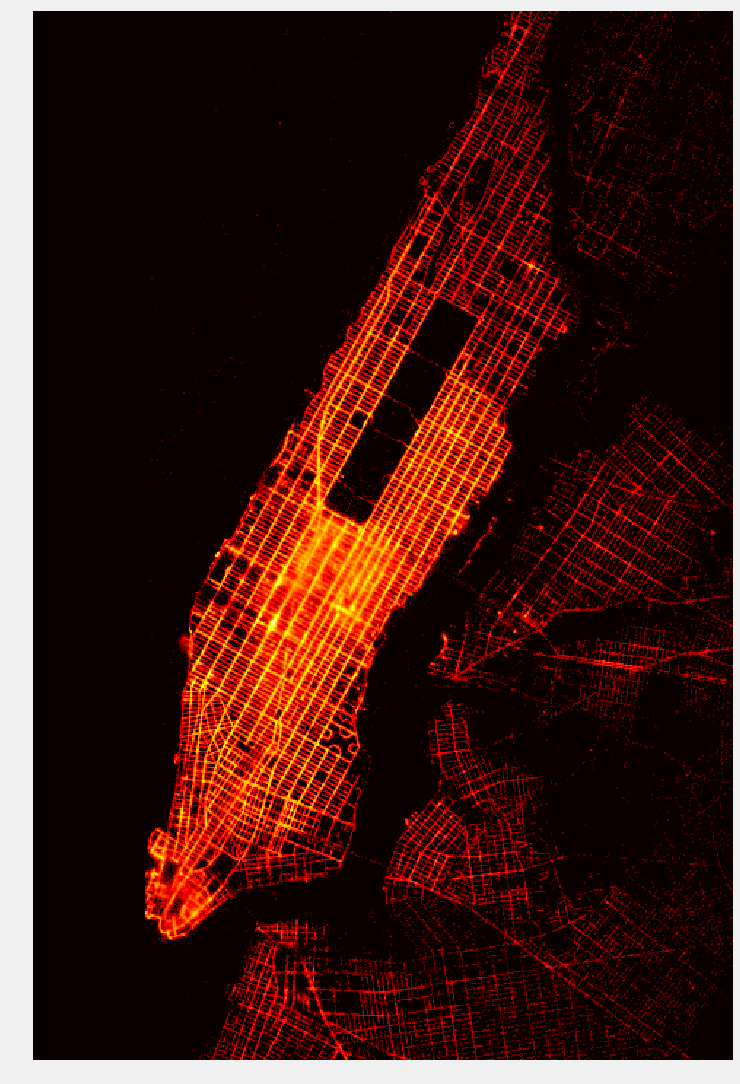

In [89]:
# zoom in on Manhattan 
imageSizeMan = (720,480)
latRangeMan = [-8,10]
longRangeMan = [-5,7]

indToKeep  = np.logical_and(allLat > latRangeMan[0], allLat < latRangeMan[1])
indToKeep  = np.logical_and(indToKeep, np.logical_and(allLong > longRangeMan[0], allLong < longRangeMan[1]))
allLatMan  = allLat[indToKeep]
allLongMan = allLong[indToKeep]

allLatIndsMan  = (imageSizeMan[0]-1) - (imageSizeMan[0] * (allLatMan  - latRangeMan[0])
                                                        / (latRangeMan[1] - latRangeMan[0])).astype(int)
allLongIndsMan =                       (imageSizeMan[1] * (allLongMan - longRangeMan[0])
                                                        / (longRangeMan[1] - longRangeMan[0])).astype(int)

locationDensityImageMan = np.zeros(imageSizeMan)
for latInd, longInd in zip(allLatIndsMan,allLongIndsMan):
    locationDensityImageMan[latInd,longInd] += 1

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,18))
ax.imshow(np.log(locationDensityImageMan+1),cmap='hot')
ax.set_axis_off()

In [90]:
#%% create some new usefull fields
pickupTime = pd.to_datetime(taxiDB['pickup_datetime'])

taxiDB['src hourOfDay'] = (pickupTime.dt.hour*60.0 + pickupTime.dt.minute)   / 60.0
taxiDB['dst hourOfDay'] = taxiDB['src hourOfDay'] + taxiDB['duration [min]'] / 60.0

taxiDB['dayOfWeek']     = pickupTime.dt.weekday
taxiDB['hourOfWeek']    = taxiDB['dayOfWeek']*24.0 + taxiDB['src hourOfDay']

taxiDB['monthOfYear']   = pickupTime.dt.month
taxiDB['dayOfYear']     = pickupTime.dt.dayofyear
taxiDB['weekOfYear']    = pickupTime.dt.weekofyear
taxiDB['hourOfYear']    = taxiDB['dayOfYear']*24.0 + taxiDB['src hourOfDay']

(0, 81)

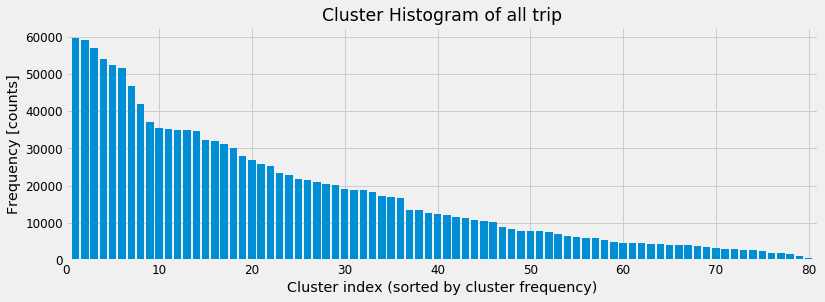

In [91]:
tripAttributes = np.array(taxiDB.loc[:,['src lat [km]','src long [km]','dst lat [km]','dst long [km]','duration [min]']])
meanTripAttr = tripAttributes.mean(axis=0)
stdTripAttr  = tripAttributes.std(axis=0)
tripAttributes = stats.zscore(tripAttributes, axis=0)

numClusters = 80
TripKmeansModel = cluster.MiniBatchKMeans(n_clusters=numClusters, batch_size=120000, n_init=100, random_state=1)
clusterInds = TripKmeansModel.fit_predict(tripAttributes)

clusterTotalCounts, _ = np.histogram(clusterInds, bins=numClusters)
sortedClusterInds = np.flipud(np.argsort(clusterTotalCounts))

plt.figure(figsize=(12,4)); plt.title('Cluster Histogram of all trip')
plt.bar(range(1,numClusters+1),clusterTotalCounts[sortedClusterInds])
plt.ylabel('Frequency [counts]'); plt.xlabel('Cluster index (sorted by cluster frequency)')
plt.xlim(0,numClusters+1)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


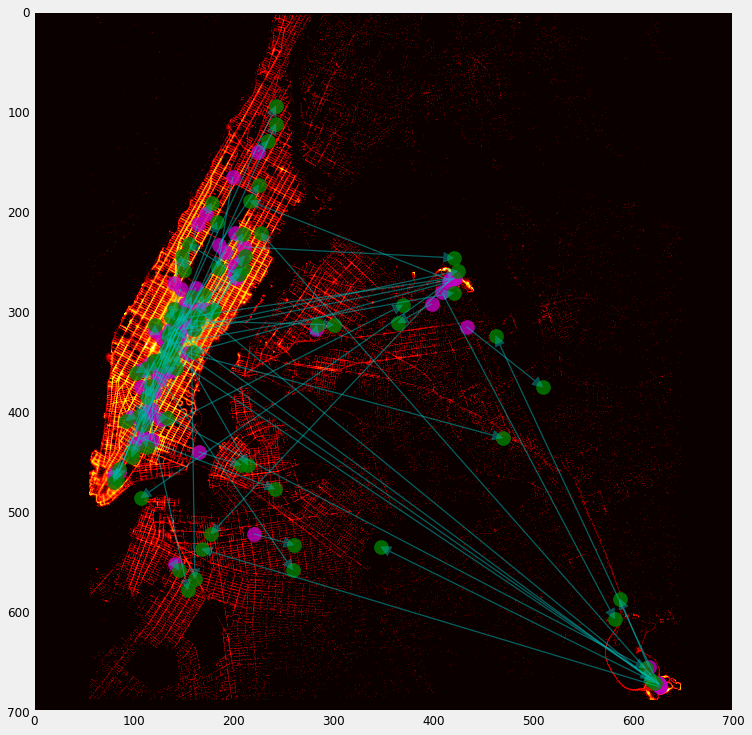

In [92]:
#%% show the templeate trips on the map
def ConvertToImageCoords(latCoord, longCoord, latRange, longRange, imageSize):
    latInds  = imageSize[0] - (imageSize[0] * (latCoord  - latRange[0])  / (latRange[1]  - latRange[0]) ).astype(int)
    longInds =                (imageSize[1] * (longCoord - longRange[0]) / (longRange[1] - longRange[0])).astype(int)

    return latInds, longInds

templateTrips = TripKmeansModel.cluster_centers_ * np.tile(stdTripAttr,(numClusters,1)) + np.tile(meanTripAttr,(numClusters,1))

srcCoords = templateTrips[:,:2]
dstCoords = templateTrips[:,2:4]

srcImCoords = ConvertToImageCoords(srcCoords[:,0],srcCoords[:,1], latRange, longRange, imageSize)
dstImCoords = ConvertToImageCoords(dstCoords[:,0],dstCoords[:,1], latRange, longRange, imageSize)

plt.figure(figsize=(12,12))
plt.imshow(np.log(locationDensityImage+1),cmap='hot'); plt.grid('off')
plt.scatter(srcImCoords[1],srcImCoords[0],c='m',s=200,alpha=0.8)
plt.scatter(dstImCoords[1],dstImCoords[0],c='g',s=200,alpha=0.8)

for i in range(len(srcImCoords[0])):
    plt.arrow(srcImCoords[1][i],srcImCoords[0][i], dstImCoords[1][i]-srcImCoords[1][i], dstImCoords[0][i]-srcImCoords[0][i], 
              edgecolor='c', facecolor='c', width=0.8,alpha=0.4,head_width=10.0,head_length=10.0,length_includes_head=True)

In [75]:
original_data = train.copy()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456003 entries, 0 to 1458643
Data columns (total 16 columns):
id                    1456003 non-null object
vendor_id             1456003 non-null int64
pickup_datetime       1456003 non-null object
dropoff_datetime      1456003 non-null object
passenger_count       1456003 non-null int64
pickup_longitude      1456003 non-null float64
pickup_latitude       1456003 non-null float64
dropoff_longitude     1456003 non-null float64
dropoff_latitude      1456003 non-null float64
store_and_fwd_flag    1456003 non-null object
trip_duration         1456003 non-null int64
duration [min]        1456003 non-null float64
src lat [km]          1453366 non-null float64
src long [km]         1453366 non-null float64
dst lat [km]          1453366 non-null float64
dst long [km]         1453366 non-null float64
dtypes: float64(9), int64(3), object(4)
memory usage: 188.8+ MB


In [ ]:
train.passenger_count = train.passenger_count.astype(np.uint8)
train.vendor_id = train.vendor_id.astype(np.uint8)
train.trip_duration = train.trip_duration.astype(np.uint32)
train.store_and_fwd_flag = train.store_and_fwd_flag.astype('category')

In [ ]:
train.info()

In [ ]:
train  = original_data.iloc[:100000]
train.pickup_datetime = pd.to_datetime(train.pickup_datetime,  format="%Y-%m-%d %H:%M:%S")
train.dropoff_datetime = pd.to_datetime(train.pickup_datetime,  format="%Y-%m-%d %H:%M:%S")
train.info()

In [ ]:
print(train.trip_duration.min())
print(train.trip_duration.max())
print('max time', train.trip_duration.max()/(60*60))

In [ ]:
train.shape

In [ ]:
print(train.isnull().sum()) # nice, no N/A values

In [ ]:
train['day_week'] = train.pickup_datetime.dt.dayofweek
train['week'] = train.pickup_datetime.dt.week
train['month'] = train.pickup_datetime.dt.month
train['time'] = train.pickup_datetime.dt.time
train.head()

In [ ]:
train.info()

In [ ]:
train.head(10)

In [ ]:
train['was_weekend'] = ((train.day_week == 6) | (train.day_week == 7)).astype(int)

In [ ]:
train.info()
train.time.dtype

In [ ]:
train.drop('time', axis = 1)

In [ ]:
train.head()

In [ ]:
train.time = train.pickup_datetime.apply(lambda x : pd.to_timedelta(str(x).split()[1]))

In [ ]:
train.info()

In [ ]:
morning_times = pd.to_timedelta(['07:00:00', '10:00:00'])
evening_times = pd.to_timedelta(['16:00:00', '19:00:00'])

print(morning_times, evening_times)

In [ ]:
print(train.time[1])
print(morning_times[1])
train.time[1]<morning_times[1]
train.head()
#print(train.time[1] in morning_times | train.time[1] in evening_times)

In [ ]:
def rushHourTravel(data):
    if (((data >= morning_times[0]) & (data <= morning_times[1])) | ((data>= evening_times[0]) & (data<=evening_times[1]))):
        return True
    else:
        return False

In [ ]:
train['rush_hour_travelled'] = train.apply((lambda x : rushHourTravel(x['time'])),axis=1)
train.head()

In [ ]:
train[['time','rush_hour_travelled']].head(50)
train['SUV'] = train.passenger_count > 4

In [ ]:
import matplotlib.pyplot as plt

train_filter = train.drop(list(np.array(train[train.trip_duration >10800].index)))
train_filter = pd.get_dummies(train_filter, columns=['vendor_id'], drop_first= True)


In [ ]:
print(train_filter[train_filter.trip_duration >10800])
print(train_filter.vendor_id_2.unique())

In [ ]:
#train_filter.to_csv('C://Users//amank//Desktop//leaned_file_new_york.csv')

In [ ]:
train_filter.plot(kind = "scatter", x="pickup_longitude", y="trip_duration")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [ ]:
print(train_filter.index)
train_filter.set_index('id',inplace=True)

In [ ]:
#target = trip_duration
train_target = train_filter.trip_duration
train_predictors = train_filter.drop('trip_duration', axis = 1)
print( train_predictors.columns)

In [ ]:
print(train_predictors.dtypes)
train_predictors = train_predictors.drop(['time','pickup_datetime','dropoff_datetime','store_and_fwd_flag'], axis = 1)
train_predictors.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_predictors, train_target, test_size = 0.3, random_state=42)
linear_reg = LinearRegression()

In [ ]:
linear_reg.fit(X_train, y_train)
y_predicted = linear_reg.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(y_test,y_predicted)

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
lasso = Lasso(alpha = 0.4 , normalize = True)

In [ ]:
lasso.fit(X_train, y_train)
y_lasso_predicted = lasso.predict(X_test)

In [ ]:
mean_squared_error(y_lasso_predicted, y_test)

In [ ]:
lasso.score(X_test, y_test)

In [ ]:
linear_reg.score(X_train, y_train)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
regr = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=100)

In [ ]:
regr.fit(X_train,y_train)

In [ ]:
regr.feature_importances_

In [ ]:
y_pred = regr.predict(X_test)

In [ ]:
regr.score(X_test,y_test)

In [ ]:
regr.score()

In [ ]:
train_pred_reg = train_filter.drop('trip_duration', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(train_predictors, train_target, test_size = 0.3, random_state=42)

In [ ]:
from sklearn.neural_network import MLPRegressor
nn_reg = MLPRegressor(hidden_layer_sizes=(5,2), random_state=1)

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scalar = StandardScaler()
scalar.fit(X_train)
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

In [ ]:
nn_reg.fit(X_train, y_train)

In [ ]:
nn_y_pred = nn_reg.predict(X_test)

In [ ]:
mean_squared_error(y_test, nn_y_pred)

In [ ]:
nn_reg.score(X_test, y_test)

In [ ]:
regr = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=100)
regr.fit(X_train,y_train)
regr.feature_importances_

In [ ]:
train_pred_reg.columns

In [ ]:
sorted(list(zip(train_pred_reg.columns, regr.feature_importances_)), key= lambda x: x[1], reverse=True)

In [ ]:
regr.score(X_test, y_test)

In [ ]:
regr = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=100)
regr.fit(X_train,y_train)
regr.feature_importances_

In [ ]:
regr.score(X_test, y_test)

In [ ]:
random_10_predict = regr.predict(X_test)
mean_squared_error(y_test,random_10_predict)

In [ ]:
sorted(list(zip(train_pred_reg.columns, regr.feature_importances_)), key= lambda x: x[1], reverse=True)

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
neighbors = NearestNeighbors(n_neighbors= 5, algorithm='ball_tree').fit(train_pred_reg[['pickup_longitude', 'pickup_latitude']])
distances, indices = neighbors.kneighbors(train_pred_reg[['pickup_longitude', 'pickup_latitude']])

In [ ]:
distances, indices

In [ ]:
type(indices)

In [ ]:
indices[:10]

In [ ]:
indices.shape

In [ ]:
from sklearn import cluster

In [ ]:
train_predi

In [ ]:
kmeans= cluster.KMeans(n_clusters=100)
kmeans.fit(train_predictors[['pickup_longitude', 'pickup_latitude']])

In [ ]:
kmeans1 = cluster.KMeans(n_clusters = 100)
kmeans1.fit(train_predictors[['dropoff_longitude','dropoff_latitude']])

In [ ]:
kmeans.labels_

In [ ]:
train_predictors['dropoff_cluster'] = kmeans1.labels_

In [ ]:
train_predictors['pickup_cluster'] = kmeans.labels_

In [ ]:
train_pred_reg.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_predictors, train_target, test_size = 0.3, random_state=42)
# X_train  = X_train.drop(['pickup_datetime','dropoff_datetime','store_and_fwd_flag','time'], axis =1 )
# X_test  = X_test.drop(['pickup_datetime','dropoff_datetime','store_and_fwd_flag','time'], axis =1 )
print(X_train.info())
regr = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=100)
regr.fit(X_train,y_train)
regr.feature_importances_
sorted(list(zip(X_train.columns, regr.feature_importances_)), key= lambda x: x[1], reverse=True)

In [ ]:
from sklearn.metrics import mean_squared_error
y_pred =regr.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))

In [ ]:
print(regr.score(X_test, y_test))